### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from filtering.enkf import EnKF
from model import LinearModel
from utils import default_generator
from utils.plotter import Plotter

from filtering.dummy.dummy_KF import kalman_filter

### Parameters

In [2]:
generator = default_generator

init_state = np.array([np.pi / 2, 0.5])
init_state_cov = 0.5 * np.eye(len(init_state))
n_states = len(init_state)
n_obs = 2
M = lambda _: np.array([[0, 1], [-1, 0]])
M = lambda _: np.array([[0, 1], [-2, -0.5]])
# H = lambda _: np.array([[1, 0]])
H = lambda _: np.eye(n_obs)
system_cov = lambda _: 0.05 * np.eye(n_states)
obs_cov = lambda _: 0.01 * np.eye(n_obs)

time_step = 0.1
init_time = 0
end_time = 30

### Generate true state

In [3]:
model = LinearModel(
    init_state, time_step, M, H, system_cov, obs_cov, generator, solver="rk4"
)
times, states = model.integrate(init_time, end_time)

### Generate observations (with noise)

In [4]:
assimilation_times = np.arange(1, end_time, 1)
observed = np.zeros((n_obs, len(assimilation_times)))
observed_true = np.zeros((n_obs, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = model.observe(states[:, k], add_noise=True)
    observed_true[:, i] = model.observe(states[:, k])

### EnKF twin experiment

100%|██████████| 29/29 [00:00<00:00, 39.21it/s]


<Figure size 640x480 with 0 Axes>

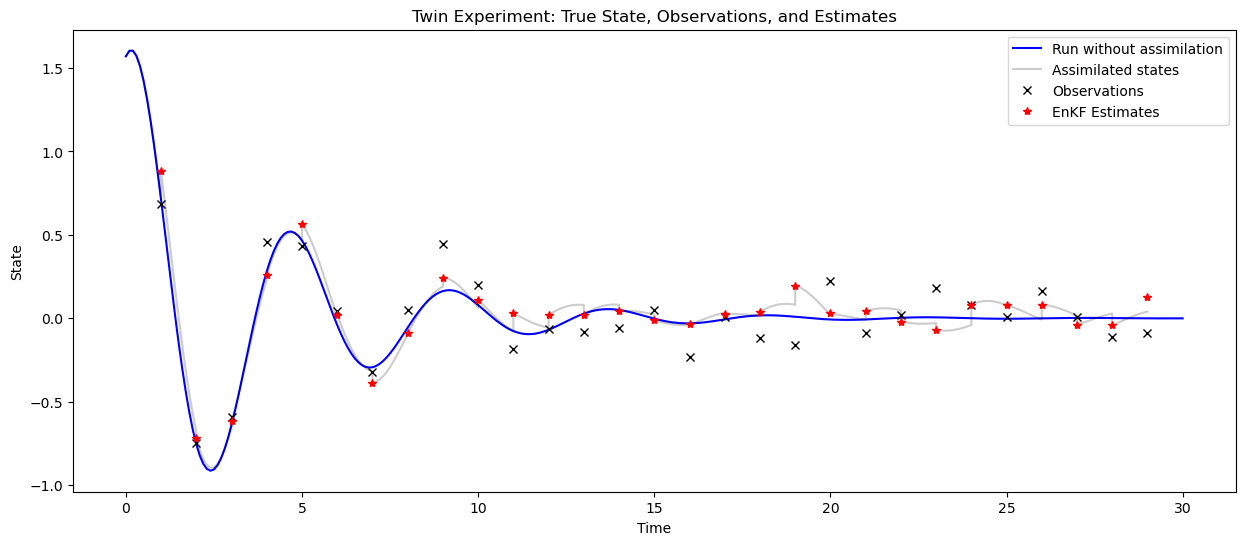

In [5]:
ensemble_size = 40
assimilation_data = observed
model.reset_model()
# f = KF(model, init_state, init_state_cov, generator)
f = EnKF(model, init_state, init_state_cov, ensemble_size, H)

# Test previous KF implementation
results = f.filter(
    assimilation_times.tolist(),
    observed_true,
    cut_off_time=None,
)
results.true_times = times
results.true_states = states

# Plotting
plt.cla()
plt.clf()
plt.figure(figsize=(15, 6))
i = 0
plt.plot(times, states[i, :], "b", label="Run without assimilation")
plt.plot(
    model.times,
    model.states[i, :],
    "k",
    label="Assimilated states",
    alpha=0.2,
)
# plt.plot(
#     assimilation_times,
#     observed_true[i, :],
#     "bo",
#     label="True observation" if i == 0 else None,
# )
plt.plot(assimilation_times, assimilation_data[i, :], "kx", label="Observations")
plt.plot(
    assimilation_times, results.estimated_states[i, :], "r*", label="EnKF Estimates"
)
plt.legend()
plt.title("Twin Experiment: True State, Observations, and Estimates")
plt.xlabel("Time")
plt.ylabel("State")
plt.show()

### Add bias to the model

100%|██████████| 29/29 [00:00<00:00, 45.49it/s]


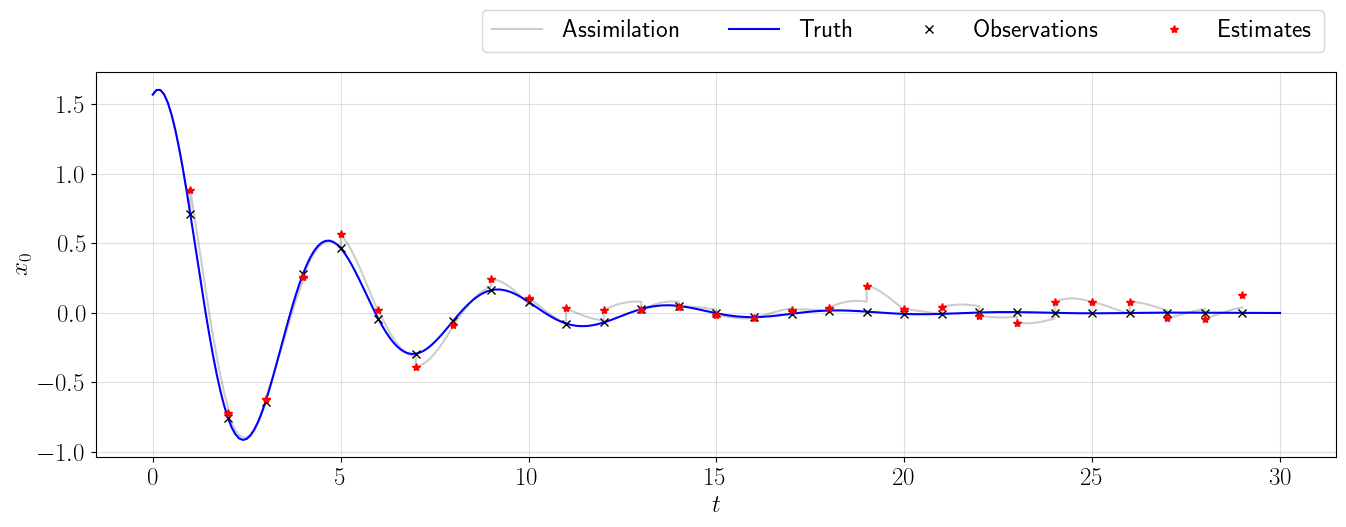

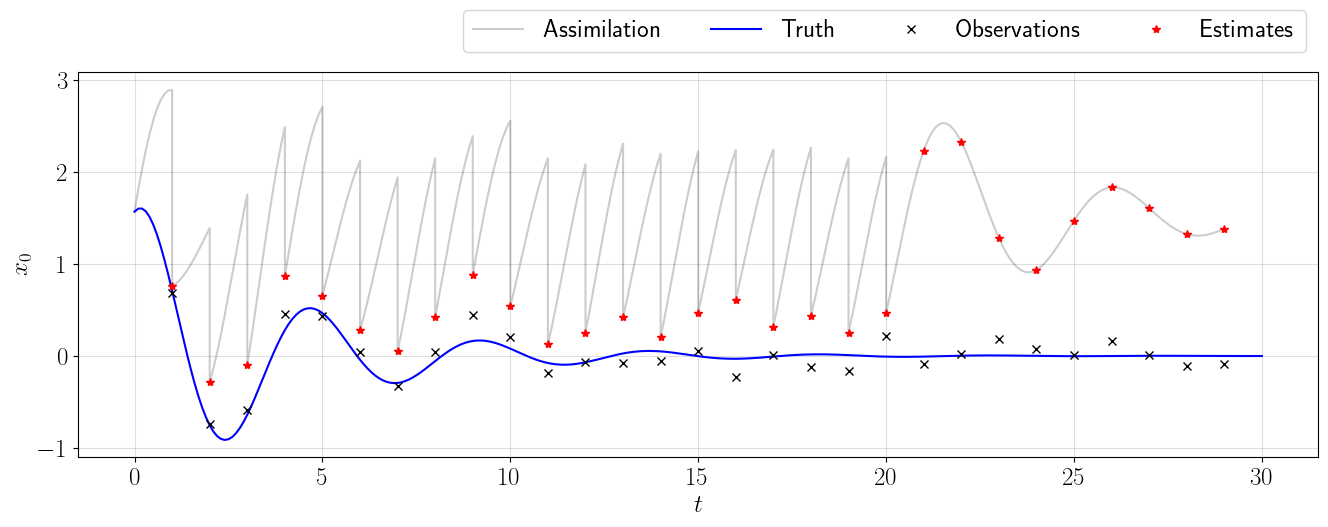

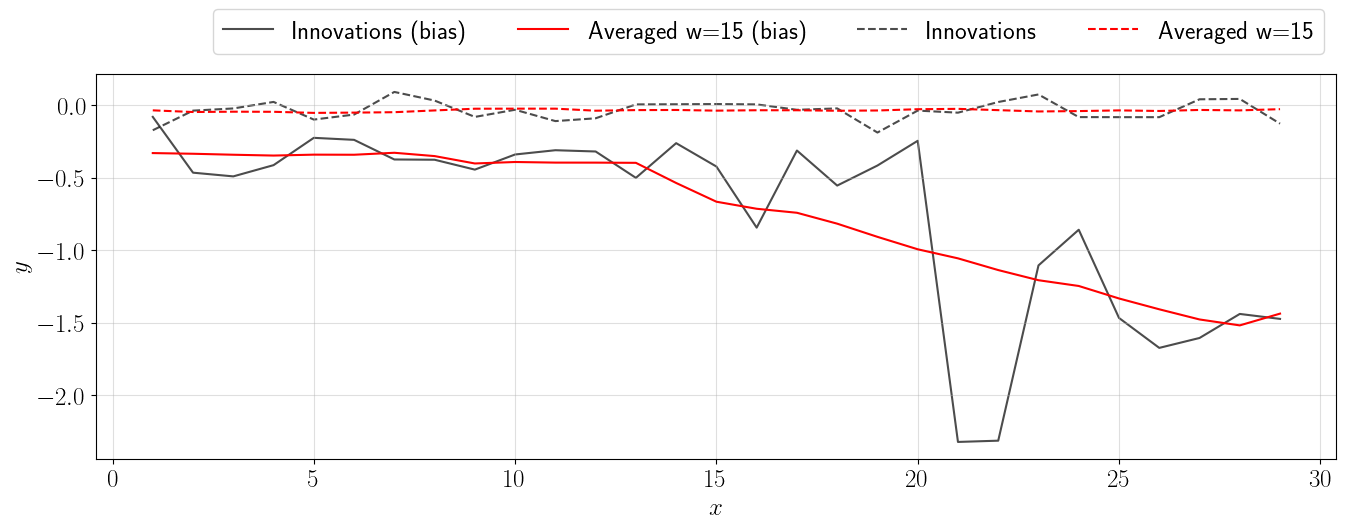

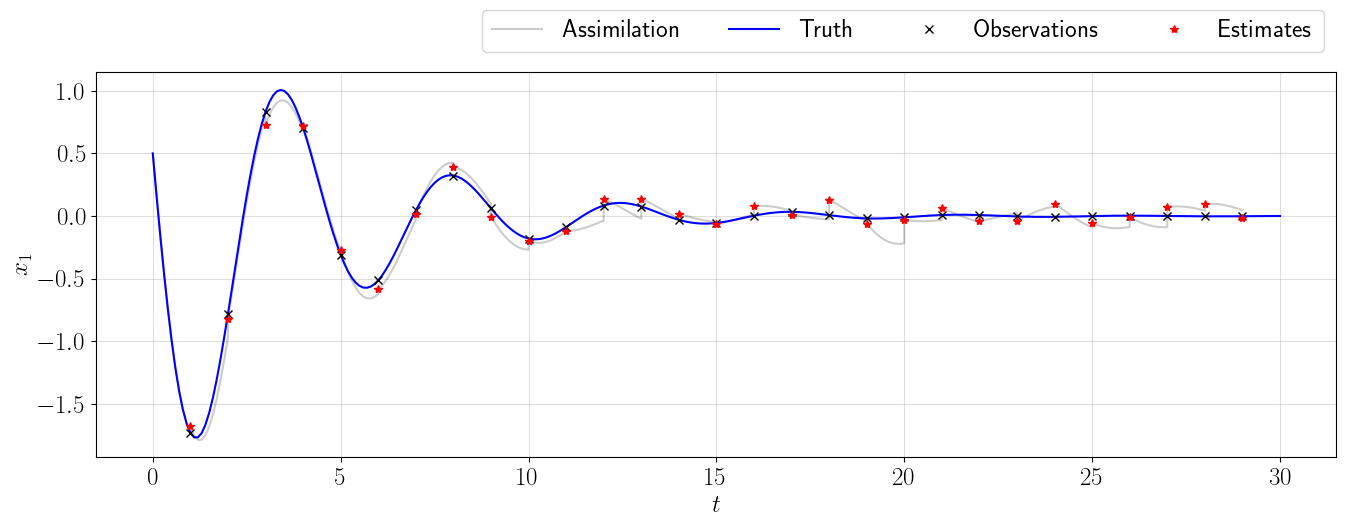

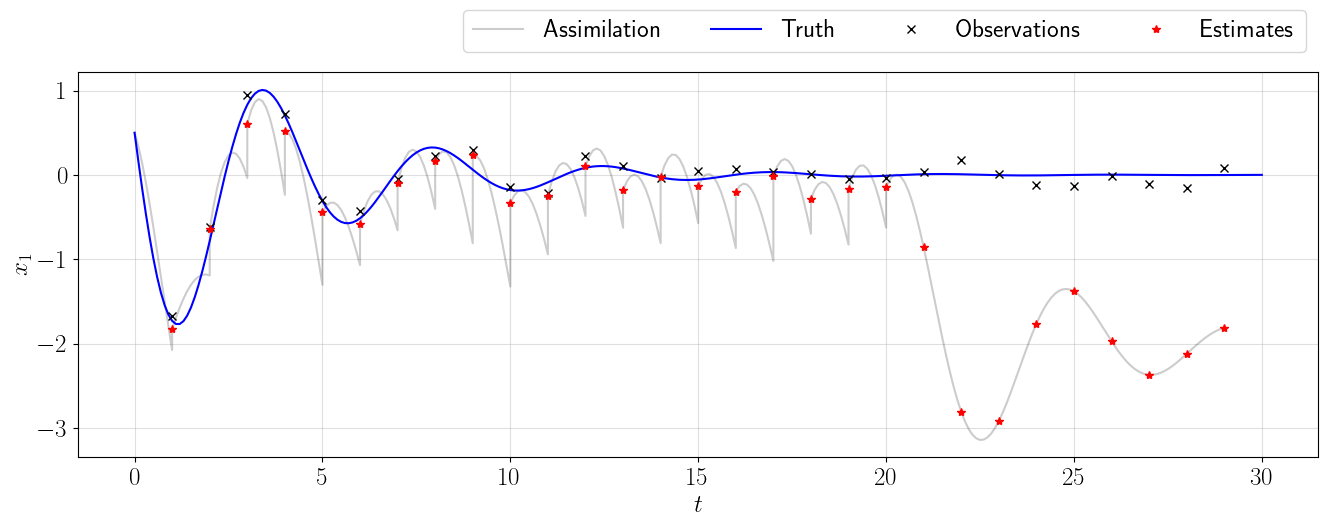

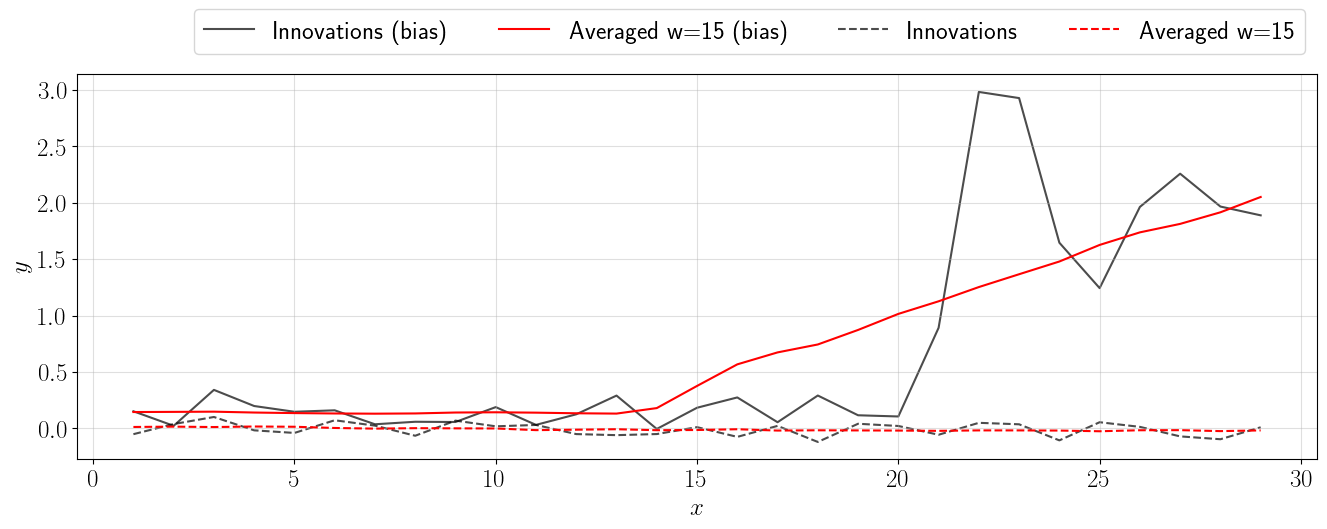

In [6]:
model.model_bias = lambda t, x: 2 * np.ones_like(init_state)
model.reset_model()

cut_off_time = 20
f = EnKF(model, init_state, init_state_cov, ensemble_size, H)
results_biased = f.filter(
    assimilation_times, observed, cut_off_time=cut_off_time, run_id="bias"
)
results_biased.true_times = times
results_biased.true_states = states

sample = [0, 1]
window = 15
for state_idx in sample:
    results.plot_filtering(state_idx, path=f"filter_{state_idx}.pdf")
    results_biased.plot_filtering(state_idx, path=f"filter_biased_{state_idx}.pdf")

    ax = results_biased.plot_innovations(state_idx, window=window)
    results.plot_innovations(
        state_idx,
        path=f"innovations_{state_idx}.pdf",
        ax=ax,
        window=window,
        linestyle="--",
    )
plt.show()